In [ ]:
#import os, sys
#from google.colab import drive
#drive.mount('/content/drive')

#my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
#os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
#sys.path.insert(0, my_path)

In [ ]:
#!pip install --target=$my_path segmentation_models_pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os
sys.path.append('/content/drive/MyDrive/Te/src')

In [ ]:
import torch
import cv2
import matplotlib.pyplot as plt

save_path = '/content/drive/MyDrive/Colab Notebooks/my_env'

sys.path.insert(0, save_path)

In [ ]:
from Models import Unet

## 모델 로드

- `[DAMAGE][Breakage_3]Unet.pt` : 파손
- `[DAMAGE][Crushed_2]Unet.pt` : 찌그러짐
- `[DAMAGE][Scratch_0]Unet.pt` : 스크래치
- `[DAMAGE][Seperated_1]Unet.pt` : 이격
-
### 데이터셋

[차량 파손 이미지 - AI허브](https://www.aihub.or.kr/aihubdata/data/view.do?dataSetSn=581)

In [ ]:
sys.path.append('/content/drive/MyDrive/Te/models')
print(sys.path)

In [ ]:
# 기존 코드
# weight_path = 'models/[DAMAGE][Breakage_3]Unet.pt'
# weight_path = 'models/[DAMAGE][Crushed_2]Unet.pt'
# weight_path = 'models/[DAMAGE][Scratch_0]Unet.pt'
# weight_path = 'models/[DAMAGE][Seperated_1]Unet.pt'

# 수정된 코드
weight_path = '/content/drive/MyDrive/Te/models/[DAMAGE][Scratch]Unet.pt'

n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
model.eval()

print('Loaded pretrained model!')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 126MB/s]


Loaded pretrained model!


## 이미지 로드

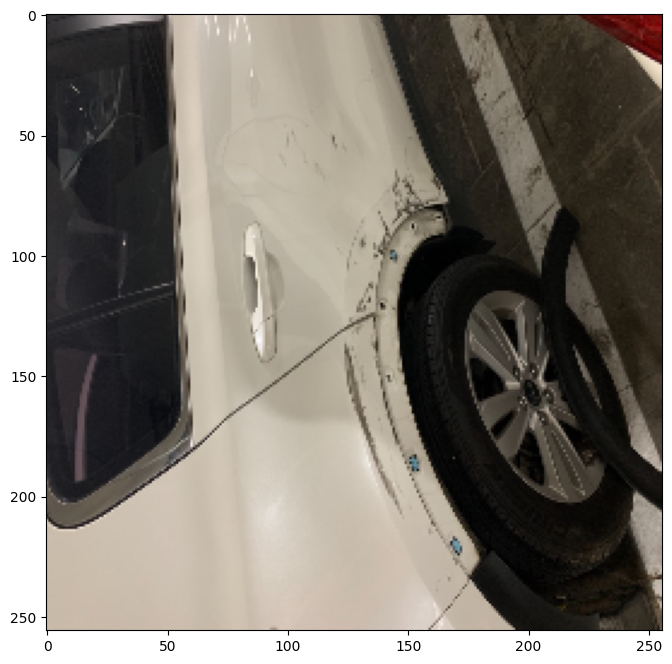

In [ ]:
img_path = '/content/drive/MyDrive/Te/samples/damage/0000565_sc-163434.jpg' # Scratch

img  = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(img)

## 이미지 전처리

In [ ]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

img_input.shape

torch.Size([1, 3, 256, 256])

## 모델 추론

In [ ]:
output = model(img_input)

output.shape

torch.Size([1, 2, 256, 256])

## 후처리 및 추론 마스크 시각화

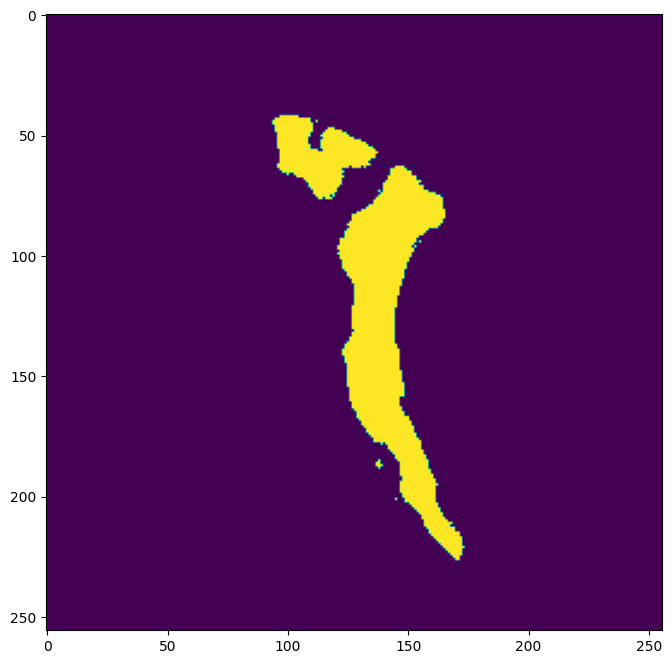

In [ ]:
img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
img_output = img_output.transpose([1, 2, 0])

plt.figure(figsize=(8, 8))
plt.imshow(img_output)

## 결과

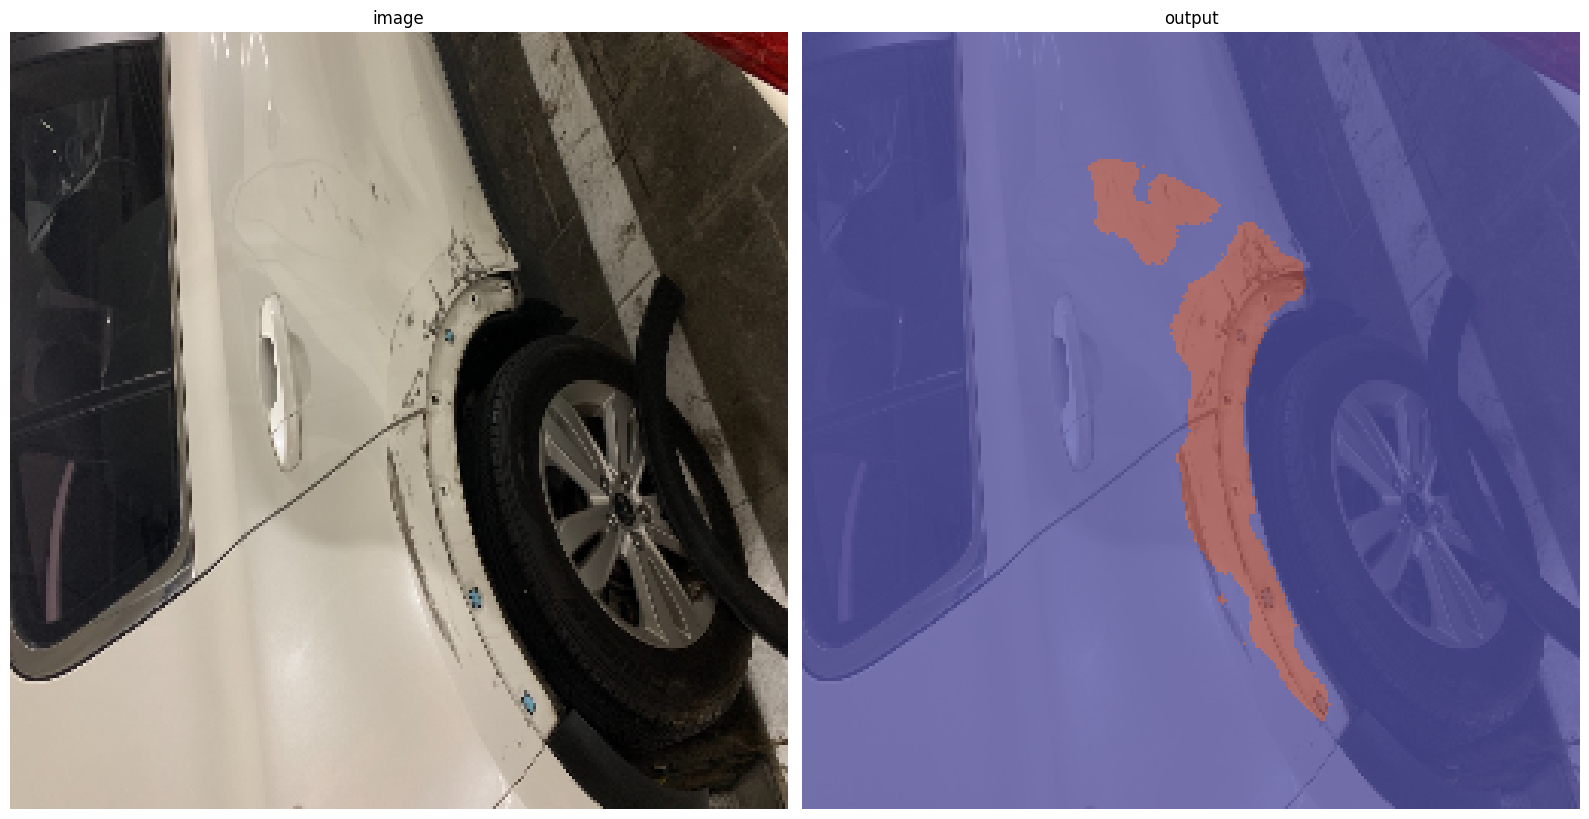

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

ax[0].imshow(img)
ax[0].set_title('image')
ax[0].axis('off')

ax[1].imshow(img.astype('uint8'), alpha=0.5)
ax[1].imshow(img_output, cmap='jet', alpha=0.5)
ax[1].set_title('output')
ax[1].axis('off')

fig.set_tight_layout(True)
plt.show()

# 여러 형태의 파손 영역 감지

In [ ]:
labels = ['Breakage', 'Crushed', 'Scratch', 'Seperated']
models = []

n_classes = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for label in labels:
    model_path = f'/content/drive/MyDrive/Te/models/[DAMAGE][{label}]Unet.pt'

    model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
    model.model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    models.append(model)

print('Loaded pretrained models!')

Loaded pretrained models!


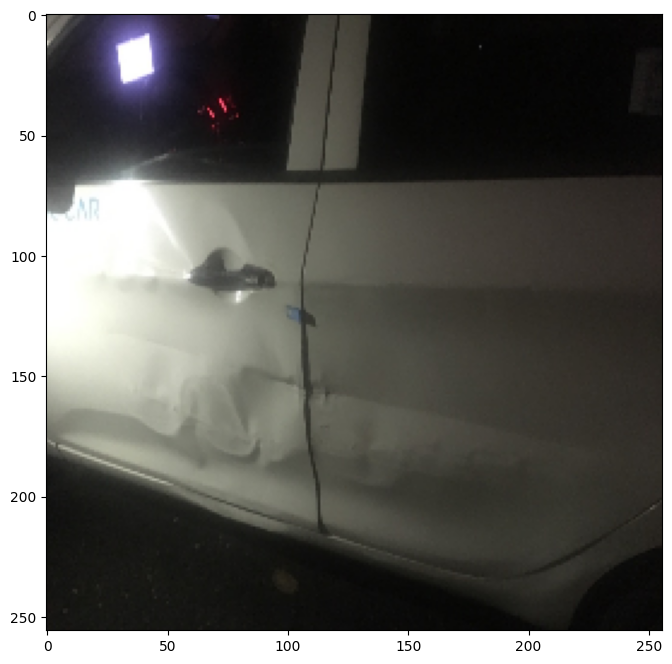

In [ ]:
img_path = '/content/drive/MyDrive/spacing/train/images/20240302.jpeg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))

plt.figure(figsize=(8, 8))
plt.imshow(img)

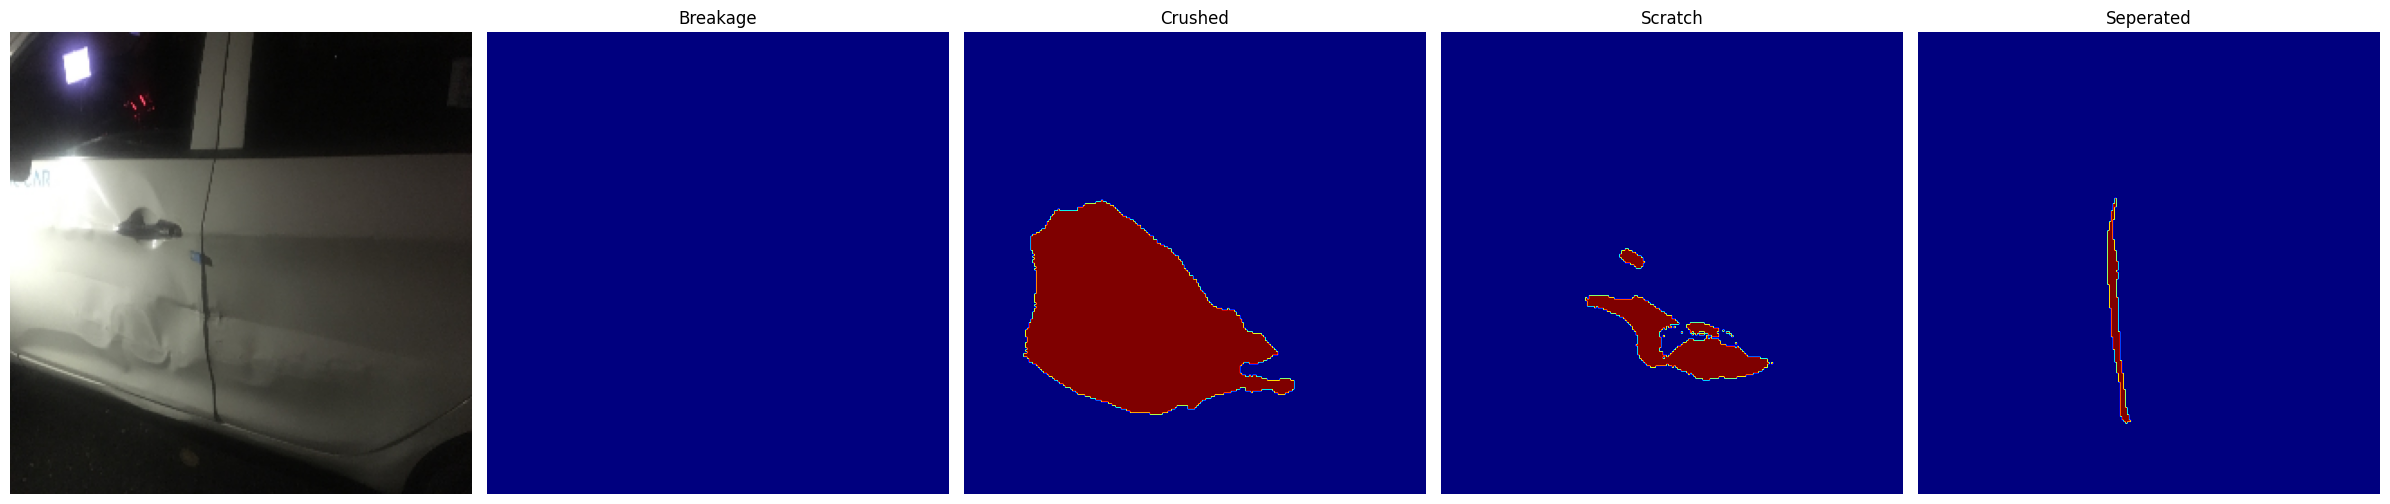

In [ ]:
img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

fig, ax = plt.subplots(1, 5, figsize=(24, 10))

ax[0].imshow(img)
ax[0].axis('off')

outputs = []

for i, model in enumerate(models):
    output = model(img_input)

    img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
    img_output = img_output.transpose([1, 2, 0])

    outputs.append(img_output)

    ax[i+1].set_title(labels[i])
    ax[i+1].imshow(img_output, cmap='jet')
    ax[i+1].axis('off')

fig.set_tight_layout(True)
plt.show()

##  파손 영역 크기 계산

In [ ]:
for i, label in enumerate(labels):
    print(f'{label}: {outputs[i].sum()}')

Breakage: 0
Crushed: 10508
Scratch: 1845
Seperated: 453


## 파손 영역 크기에 따른 가격 산출 (예시)

손상심각도 계산

In [ ]:
# 전체 면적 계산
weight_path = '/content/drive/MyDrive/Te/models/[PART]Unet.pt'

n_classes = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Unet(encoder='resnet34', pre_weight='imagenet', num_classes=n_classes).to(device)
model.model.load_state_dict(torch.load(weight_path, map_location=torch.device(device)))
model.eval()

img_input = img / 255.
img_input = img_input.transpose([2, 0, 1])
img_input = torch.tensor(img_input).float().to(device)
img_input = img_input.unsqueeze(0)

output = model(img_input)

img_output = torch.argmax(output, dim=1).detach().cpu().numpy()
img_output = img_output.transpose([1, 2, 0])

area_sum = img_output.sum()

# 각각 손상부위별 면적
area_breakage = outputs[0].sum()
area_crushed = outputs[1].sum()
area_scratch = outputs[2].sum()
area_seperated = outputs[3].sum()
print(area_sum, area_breakage, area_crushed, area_scratch, area_seperated)

750 0 10508 1845 453


In [ ]:
severity = (area_breakage*3.0 + area_crushed*2.0 + area_seperated*1.2 + area_scratch*1.0) * 100 / (3*area_sum)
severity

1040.2044444444443

In [ ]:
if 0 <= severity < 6:
    grade = 1
elif  severity < 26:
    grade = 2
elif  severity < 51:
    grade = 3
elif  severity < 81:
    grade = 4
else:
    grade = 5

print('손상심각도 :', grade, '등급')

손상심각도 : 5 등급


손상심각도에 따른 부위별 수리비용 결정

In [ ]:
if grade == 1:
  price_table = [
      200, # Breakage_3
      150, # Crushed_2
      50,  # Scratch_0
      120, # Seperated_1
  ]
if grade == 2:
  price_table = [
      220, # Breakage_3
      170, # Crushed_2
      70,  # Scratch_0
      140, # Seperated_1
  ]
if grade == 3:
  price_table = [
      240, # Breakage_3
      190, # Crushed_2
      90,  # Scratch_0
      160, # Seperated_1
  ]
if grade == 4:
  price_table = [
      260, # Breakage_3
      210, # Crushed_2
      110,  # Scratch_0
      180, # Seperated_1
  ]
if grade == 5:
  price_table = [
      280, # Breakage_3
      230, # Crushed_2
      130,  # Scratch_0
      200, # Seperated_1
  ]

손상심각도와 픽셀당 수리비용 산출

In [ ]:
total = 0

for i, price in enumerate(price_table):
    area = outputs[i].sum()
    total += area * price

    print(f'{labels[i]}:\t영역: {area}\t가격:{area * price}원')

print('손상심각도 :', grade, '등급')
print(f'총 수리비는 {total}원 입니다.')

Breakage:	영역: 0	가격:0원
Crushed:	영역: 10508	가격:2416840원
Scratch:	영역: 1845	가격:239850원
Seperated:	영역: 453	가격:90600원
손상심각도 : 5 등급
총 수리비는 2747290원 입니다.
